In [1]:
import os
import csv
import re
from tqdm import tqdm
import requests
import zipfile

# Define dataset URLs
CXR_URL = "https://data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Shenzhen-Hospital-CXR-Set/CXR_png/index.html"
READINGS_URL = "https://data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Shenzhen-Hospital-CXR-Set/ClinicalReadings/index.html"

# Download function
def download_dataset(url, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    !wget -r -np -nH --cut-dirs=3 -R "index.html*" -P {output_dir} {url}

# Download datasets
print("Downloading CXR images...")
download_dataset(CXR_URL, "CXR_png")
print("Downloading clinical readings...")
download_dataset(READINGS_URL, "ClinicalReadings")

# Preprocess .txt files to generate prompts
def preprocess_text_files(clinical_readings_dir, cxr_dir, output_csv):
    csv_rows = [["filename", "findings"]]
    for txt_file in tqdm(os.listdir(clinical_readings_dir)):
        if txt_file.endswith(".txt"):
            txt_path = os.path.join(clinical_readings_dir, txt_file)
            with open(txt_path, "r") as f:
                lines = f.read().strip().split("\n")

            # Extract gender and age
            match = re.match(r"([a-zA-Z]+)\s*(\d+)yrs", lines[0])
            if match:
                gender = match.group(1).capitalize()
                age = match.group(2)
            else:
                continue

            # Extract findings
            findings = ". ".join(lines[1:])
            prompt = f"Age: {age}, Gender: {gender}, findings: {findings}"

            # Find matching image
            image_name = txt_file.replace(".txt", ".png")
            if os.path.exists(os.path.join(cxr_dir, image_name)):
                csv_rows.append([image_name, prompt])

    # Write to CSV
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(csv_rows)

# Run preprocessing
preprocess_text_files("ClinicalReadings", "CXR_png", "dataset.csv")
print("Preprocessing complete. Dataset saved as dataset.csv.")


Streaming output truncated to the last 5000 lines.
Length: 18 [text/plain]
Saving to: ‘ClinicalReadings/ClinicalReadings/CHNCXR_0163_0.txt’

ClinicalReadings/CH 100%[===================>]      18  --.-KB/s    in 0s      

2025-01-28 10:49:50 (10.2 MB/s) - ‘ClinicalReadings/ClinicalReadings/CHNCXR_0163_0.txt’ saved [18/18]

--2025-01-28 10:49:50--  https://data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Shenzhen-Hospital-CXR-Set/ClinicalReadings/CHNCXR_0164_0.txt
Reusing existing connection to data.lhncbc.nlm.nih.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 18 [text/plain]
Saving to: ‘ClinicalReadings/ClinicalReadings/CHNCXR_0164_0.txt’

ClinicalReadings/CH 100%[===================>]      18  --.-KB/s    in 0s      

2025-01-28 10:49:50 (10.0 MB/s) - ‘ClinicalReadings/ClinicalReadings/CHNCXR_0164_0.txt’ saved [18/18]

--2025-01-28 10:49:50--  https://data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Shenzhen-Hospital-CXR-Set/ClinicalRea

100%|██████████| 1/1 [00:00<00:00, 13025.79it/s]

Preprocessing complete. Dataset saved as dataset.csv.


In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Create the dataset CSV
def create_dataset_csv(clinical_readings_dir, cxr_dir, output_csv):
    data_rows = [["filename", "findings"]]
    for txt_file in os.listdir(clinical_readings_dir):
        if txt_file.endswith(".txt"):
            txt_path = os.path.join(clinical_readings_dir, txt_file)
            with open(txt_path, "r") as f:
                lines = f.read().strip().split("\n")

            # Parse the gender and age
            match = re.match(r"([a-zA-Z]+)\s*(\d+)yrs", lines[0])
            if match:
                gender = match.group(1).capitalize()
                age = match.group(2)
            else:
                continue

            # Parse findings
            findings = ". ".join(lines[1:])
            prompt = f"Age: {age}, Gender: {gender}, findings: {findings}"

            # Match image file
            image_name = txt_file.replace(".txt", ".png")
            if os.path.exists(os.path.join(cxr_dir, image_name)):
                data_rows.append([image_name, prompt])

    # Write to CSV
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data_rows)
    print(f"Dataset CSV saved at {output_csv}")

# Paths
clinical_readings_dir = "/content/ClinicalReadings/ClinicalReadings"
cxr_dir = "/content/CXR_png/CXR_png"
csv_file = "dataset.csv"

# Create dataset CSV
create_dataset_csv(clinical_readings_dir, cxr_dir, csv_file)

# Define the custom dataset
class MedicalImageDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return {
            "image": image,
            "text": row["findings"]
        }

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load dataset
dataset = MedicalImageDataset(csv_file, cxr_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"Dataset loaded. Total samples: {len(dataset)}")

# Display a sample
for sample in dataloader:
    print(f"Sample image batch shape: {sample['image'].shape}")
    print(f"Sample text batch: {sample['text'][:3]}")
    break


Dataset CSV saved at dataset.csv
Dataset loaded. Total samples: 632
Sample image batch shape: torch.Size([16, 3, 256, 256])
Sample text batch: ['Age: 34, Gender: Male, findings: Right PTB', 'Age: 37, Gender: Male, findings: . normal', 'Age: 50, Gender: Male, findings: bilateral PTB']


In [3]:
import os, gc, sys, time, random, math
import torch
import torch.nn as nn
import torch.nn.functional as F


from typing import Optional, List

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

try:
    from diffusers import StableDiffusionPipeline
except:
    !pip install diffusers -q
    from diffusers import StableDiffusionPipeline

from tqdm import tqdm

from PIL import Image

import numpy as np
import pandas as pd

DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seedBasic(); seedTorch();

def clear_cache():
    torch.cuda.empty_cache(); gc.collect(); time.sleep(1); torch.cuda.empty_cache(); gc.collect();


def check_and_make_folder(path):
    if not os.path.exists(path):
        os.system(f'mkdir -p {path}')


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
def print_trainable_parameters(model):
    total_parameter_count = sum([np.prod(p.size()) for p in model.parameters()])

    trainable_parameter = filter(lambda p: p.requires_grad, model.parameters())
    trainable_parameter_count = sum([np.prod(p.size()) for p in trainable_parameter])

    trainable_percentage = (trainable_parameter_count / total_parameter_count)  * 100

    formatted_output = (
        f"trainable params: {trainable_parameter_count:,} || "
        f"all params: {total_parameter_count:,} || "
        f"trainable%: {trainable_percentage:.16f}"
    )

    print(formatted_output)


def remove_param_from_optimizer(optim, param):
    for j in range(len(optim.param_groups)):
        optim_param_group_list = optim.param_groups[j]["params"]
        for i, optim_param in enumerate(optim_param_group_list):
            if param.shape == optim_param.shape and (param==optim_param).all():
                del optim.param_groups[j]["params"][i]

clear_cache()

In [5]:
WEIGHT_DTYPE = torch.float32
BATCH_SIZE = 1
LR = 1e-4
# The main path
Main_Path = '/content'
# The datasets path under the main path
Data_storage = Main_Path + '/dataset'
save_result_path = Main_Path + '/Result'

### folder to save the result.
folder_name = 'LoRA'

check_and_make_folder(f'{save_result_path}/{folder_name}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_id = "runwayml/stable-diffusion-v1-5"

UNET_TARGET_MODULES = [
    "to_q", "to_k", "to_v",
    "proj", "proj_in", "proj_out",
    "conv", "conv1", "conv2",
    "conv_shortcut", "to_out.0", "time_emb_proj", "ff.net.2",
]


TEXT_ENCODER_TARGET_MODULES = ["fc1", "fc2", "q_proj", "k_proj", "v_proj", "out_proj"]

# 1

In [6]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer
from diffusers.schedulers import DDPMScheduler

# Load the Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=WEIGHT_DTYPE
).to(device)

# Extract components
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
text_encoder = pipe.text_encoder
vae = pipe.vae
unet = pipe.unet

# Freeze the bulk part of the model
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_model(text_encoder)
freeze_model(vae)
freeze_model(unet)

# Print trainable parameters to verify
print("Text Encoder Trainable Parameters:")
print_trainable_parameters(text_encoder)

print("VAE Trainable Parameters:")
print_trainable_parameters(vae)

print("UNet Trainable Parameters:")
print_trainable_parameters(unet)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Text Encoder Trainable Parameters:
trainable params: 0 || all params: 123,060,480 || trainable%: 0.0000000000000000
VAE Trainable Parameters:
trainable params: 0 || all params: 83,653,863 || trainable%: 0.0000000000000000
UNet Trainable Parameters:
trainable params: 0 || all params: 859,520,964 || trainable%: 0.0000000000000000


In [7]:
def remove_param_from_optimizer(optim, param):
    for j in range(len(optim.param_groups)):
        optim_param_group_list = optim.param_groups[j]["params"]
        for i, optim_param in enumerate(optim_param_group_list):
            if param.shape == optim_param.shape and (param==optim_param).all():
                del optim.param_groups[j]["params"][i]

clear_cache()

#2

In [8]:
class LoRALayer:
    def __init__(
        self,
        r: int,
        lora_alpha: int,
        lora_dropout: float,
        merge_weights: bool,
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        # Optional dropout
        if lora_dropout > 0.0:
            self.lora_dropout = nn.Dropout(p=lora_dropout)
        else:
            self.lora_dropout = lambda x: x
        # Mark the weight as unmerged
        self.merged = False
        self.merge_weights = merge_weights


class Linear(nn.Linear, LoRALayer):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        name='',
        r: int = 0,
        lora_alpha: int = 8,
        lora_dropout: float = 0.0,
        EMA_factor: float = 0.6,
        fan_in_fan_out: bool = False,  # Set this to True if the layer to replace stores weight like (fan_in, fan_out)
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)
        self.name = name
        self.in_features = in_features
        self.out_features = out_features
        self.r = r
        self.fan_in_fan_out = fan_in_fan_out

        # Actual trainable parameters
        if r > 0:
            # Define A and B matrices with proper shape
            self.lora_A = nn.Parameter(torch.empty((r, in_features)))
            self.lora_B = nn.Parameter(torch.empty((out_features, r)))

            # Define scaling variable
            self.scaling = lora_alpha / r

            # Freeze the pre-trained weight matrix
            self.weight.requires_grad = False

            # Initialize gradients for LoRA layer
            self.recorded_grad = 1

        # Reset parameters
        self.reset_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.T

    def get_active_rank(self):
        assert self.lora_A.shape[0] == self.lora_B.shape[1]
        return self.lora_A.shape[0]

    def reset_parameters(self):
        nn.Linear.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.lora_B, a=math.sqrt(5))

    def train(self, mode: bool = True):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        nn.Linear.train(self, mode)
        if self.merge_weights and self.merged:
            if self.r > 0:
                # De-merge LoRA weights during training
                self.weight.data -= T(self.lora_B @ self.lora_A) * self.scaling
            self.merged = False

    def eval(self):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        nn.Linear.eval(self)
        if self.merge_weights and not self.merged:
            if self.r > 0:
                # Merge LoRA weights during evaluation
                self.weight.data += T(self.lora_B @ self.lora_A) * self.scaling
            self.merged = True

    def forward(self, x: torch.Tensor, *args, **kwargs):
        def T(w):
            return w.T if self.fan_in_fan_out else w

        if self.r > 0 and not self.merged:
            # LoRA forwarding: result = W*x + alpha * (B @ A * x)
            result = F.linear(x, T(self.weight), bias=self.bias)
            result += self.lora_dropout(x) @ self.lora_A.T @ self.lora_B.T * self.scaling
            return result
        else:
            return F.linear(x, T(self.weight), bias=self.bias)


# 3

In [9]:
def set_Linear_SeLoRA(model):
    # Replace all linear layers with LoRA layers
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            # Create a LoRA-enhanced Linear layer
            LoRA_layer = Linear(
                in_features=layer.in_features,
                out_features=layer.out_features,
                r=4,  # Low-rank factor, can be adjusted
                lora_alpha=8,  # Scaling factor
                lora_dropout=0.1,  # Optional dropout
                fan_in_fan_out=False,  # Adjust if weight format differs
                bias=layer.bias is not None,
            )

            # Copy weights from the original layer to the LoRA layer
            LoRA_layer.weight.data = layer.weight.data.clone()
            if layer.bias is not None:
                LoRA_layer.bias.data = layer.bias.data.clone()

            # Freeze the pretrained weights in the LoRA layer
            LoRA_layer.weight.requires_grad = False

            # Navigate through the model hierarchy to replace the layer
            parent_module = model
            sub_layers = name.split('.')
            for layer_name in sub_layers[:-1]:
                parent_module = getattr(parent_module, layer_name)

            # Replace the original layer with the LoRA-enhanced layer
            setattr(parent_module, sub_layers[-1], LoRA_layer)
    return model


# Apply LoRA to the UNet and text encoder
unet_lora = set_Linear_SeLoRA(unet)
text_encoder_lora = set_Linear_SeLoRA(text_encoder)

# Print trainable parameters to verify
print("Text Encoder Trainable Parameters:")
print_trainable_parameters(text_encoder_lora)

print("UNet Trainable Parameters:")
print_trainable_parameters(unet_lora)


Text Encoder Trainable Parameters:
trainable params: 746,496 || all params: 123,724,032 || trainable%: 0.6033557005319710
UNet Trainable Parameters:
trainable params: 1,865,984 || all params: 861,226,948 || trainable%: 0.2166657701937121


# 4

In [10]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, df, tokenizer, size=224, center_crop=True):
        self.root_dir = root_dir
        self.files = df['filename'].tolist()
        self.findings = df['findings'].tolist()
        self.tokenizer = tokenizer

        # Define image transformations
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        example = {}

        # Load and preprocess the image
        instance_image = Image.open(
            os.path.join(self.root_dir, self.files[idx])
        ).convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)

        # Tokenize the text instance
        example["instance_prompt_ids"] = self.tokenizer(
            self.findings[idx],
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )["input_ids"].squeeze(0)  # Remove batch dimension

        return example


# 5

In [11]:
from sklearn.model_selection import train_test_split

# Read and prepare the dataset
reports = pd.read_csv('/content/dataset.csv')  # Correct path to the dataset file
reports = reports[['filename', 'findings']]

# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(reports, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 50% of temp_df for validation/test

# ImageDataset initialization
root_dir = "/content/CXR_png/CXR_png"  # Root directory for images
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")  # Initialize the tokenizer

train_ds = ImageDataset(
    root_dir=root_dir,
    df=train_df,
    tokenizer=tokenizer,
    size=224,
    center_crop=True
)

valid_ds = ImageDataset(
    root_dir=root_dir,
    df=valid_df,
    tokenizer=tokenizer,
    size=224,
    center_crop=True
)

test_ds = ImageDataset(
    root_dir=root_dir,
    df=test_df,
    tokenizer=tokenizer,
    size=224,
    center_crop=True
)

# Number of CPU cores for DataLoader
num_workers = os.cpu_count()

# DataLoader initialization
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# Example: Verify dataset and dataloader
print(f"Train set: {len(train_ds)} samples")
print(f"Validation set: {len(valid_ds)} samples")
print(f"Test set: {len(test_ds)} samples")

# Example batch
for batch in train_loader:
    print(f"Batch images shape: {batch['instance_images'].shape}")
    print(f"Batch prompt IDs shape: {batch['instance_prompt_ids'].shape}")
    break


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Train set: 505 samples
Validation set: 63 samples
Test set: 64 samples
Batch images shape: torch.Size([1, 3, 224, 224])
Batch prompt IDs shape: torch.Size([1, 77])


#6

In [12]:
# Gather parameters from LoRA layers only
trainable_params = [
    param for param in unet_lora.parameters() if param.requires_grad
] + [
    param for param in text_encoder_lora.parameters() if param.requires_grad
]

# Initialize the optimizer
optimizer = torch.optim.Adam(trainable_params, lr=LR)

# Print the number of parameters being optimized
print(f"Number of trainable parameters: {sum(p.numel() for p in trainable_params):,}")


Number of trainable parameters: 2,612,480


In [13]:
import copy  # Ensure this is imported

In [14]:
class Trainer:
    def __init__(self, vae, unet, text_encoder, noise_scheduler, optimizer, train_dl, test_dl, total_epoch, WEIGHT_DTYPE, threshould=2, per_iter_valid=60, log_period=20):
        self.vae = vae.to(device, dtype=WEIGHT_DTYPE)
        self.unet = unet.to(device, dtype=WEIGHT_DTYPE)
        self.text_encoder = text_encoder.to(device, dtype=WEIGHT_DTYPE)
        self.noise_scheduler = noise_scheduler
        self.optimizer = optimizer
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.WEIGHT_DTYPE = WEIGHT_DTYPE
        self.total_epoch = total_epoch
        self.threshould = threshould
        self.per_iter_valid = per_iter_valid
        self.log_period = log_period
        self.total_step = 0
        self.result_df = pd.DataFrame(columns=['epoch', 'steps', 'Train Loss', 'Valid Loss'])
        self._display_id = None

        self.best_text_encoder = None
        self.best_unet = None

        self.display_line = ''

        print(f'total steps: {len(train_dl) * total_epoch}')

    def valid(self):
        self.unet.eval()
        self.text_encoder.eval()
        self.vae.eval()

        valid_pbar = tqdm(self.test_dl, desc='validating', leave=False)

        valid_loss, number_of_instance = [], 0

        for step, batch in enumerate(valid_pbar):
            # Define batch, transfer to device, convert to weight's dtype, squeeze if needed.
            pixel_values = batch["instance_images"].to(device, dtype=self.WEIGHT_DTYPE)
            prompt_idxs = batch["instance_prompt_ids"].to(device).squeeze(1)

            # Convert input images (pixel values) to latent representations in the latent space using the VAE encoder
            with torch.no_grad():
                latents = self.vae.encode(pixel_values).latent_dist.sample()
                latents = latents * 0.18215  # Scale latent representations as per VAE config

            # Generate random noise of the same shape as the latents to simulate the diffusion process
            noise = torch.randn_like(latents)

            bsz = latents.shape[0]
            # Sample random timesteps for each image, uniformly drawn from the range of timesteps in the noise scheduler
            timesteps = torch.randint(0, self.noise_scheduler.config.num_train_timesteps, (bsz,), device=device)
            timesteps = timesteps.long()

            # Add noise to the latents at the selected timesteps according to the noise magnitude (forward diffusion process)
            noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

            # Encode the text prompts into hidden states using the text encoder, which provides conditioning information
            with torch.no_grad():
                encoder_hidden_states = self.text_encoder(prompt_idxs)[0]

            # Predict the noise residual using the UNet model, conditioned on the noisy latents, timesteps, and text embeddings
            with torch.no_grad():
                model_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # Define the target for the loss function
            target = noise

            # Calculate the loss between the predicted noise (model output) and the actual noise
            # This measures how well the model predicts the noise for the reverse diffusion process
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            valid_loss.append(loss.item() * len(batch))
            number_of_instance += len(batch)
            clear_cache()
            torch.cuda.empty_cache()

        ########################################################################
        ## Add log and save model here TODO
        ########################################################################

        self.unet.train()
        self.vae.train()
        self.text_encoder.train()

        torch.cuda.empty_cache()

        return sum(valid_loss) / number_of_instance

    def train(self):
        self._display_id = display(self.result_df, display_id=True)

        self.vae.train()
        self.unet.train()
        self.text_encoder.train()

        recorded_loss = []

        for epoch in range(self.total_epoch):
            pbar = tqdm(self.train_dl, desc=f"Epoch {epoch + 1}/{self.total_epoch}")
            for step, batch in enumerate(pbar):
                pixel_values = batch["instance_images"].to(device, dtype=self.WEIGHT_DTYPE)
                prompt_idxs = batch["instance_prompt_ids"].to(device).squeeze(1)

                # Convert input images (pixel values) to latent representations in the latent space using the VAE encoder
                latents = self.vae.encode(pixel_values).latent_dist.sample()
                latents = latents * 0.18215  # Scale latent representations as per VAE config

                # Generate random noise of the same shape as the latents to simulate the diffusion process
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]

                # Sample random timesteps for each image, uniformly drawn from the range of timesteps in the noise scheduler
                timesteps = torch.randint(0, self.noise_scheduler.config.num_train_timesteps, (bsz,), device=device)
                timesteps = timesteps.long()

                # Add noise to the latents at the selected timesteps according to the noise magnitude (forward diffusion process)
                noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

                # Encode the text prompts into hidden states using the text encoder, which provides conditioning information
                encoder_hidden_states = self.text_encoder(prompt_idxs)[0]

                # Predict the noise residual using the UNet model, conditioned on the noisy latents, timesteps, and text embeddings
                model_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Define the target for the loss function
                target = noise

                # Calculate the loss between the predicted noise (model output) and the actual noise
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                recorded_loss.append(loss.item())
                pbar.set_description(f"[Loss: {recorded_loss[-1]:.3f}/{np.mean(recorded_loss):.3f}]")
                self.total_step += 1

                clear_cache()

                if self.total_step % self.per_iter_valid == 0:
                    valid_rmse = self.valid()

                    if valid_rmse <= min([x for x in self.result_df['Valid Loss'] if x != ' --- '] + [1.0]):
                        self.best_text_encoder = copy.deepcopy(self.text_encoder).cpu()
                        self.best_unet = copy.deepcopy(self.unet).cpu()

                        # Save best models
                        check_and_make_folder(os.path.join(save_result_path, folder_name, 'trained_model', 'final_Unet'))
                        check_and_make_folder(os.path.join(save_result_path, folder_name, 'trained_model', 'final_Text'))

                        self.unet.save_pretrained(os.path.join(save_result_path, folder_name, 'trained_model', 'final_Unet'))
                        self.text_encoder.save_pretrained(os.path.join(save_result_path, folder_name, 'trained_model', 'final_Text'))

                    # Update result DataFrame
                    self.result_df.loc[len(self.result_df)] = [
                        epoch,
                        self.total_step,
                        np.round(np.mean(recorded_loss), 4),
                        np.round(valid_rmse, 4)
                    ]
                    self._display_id.update(self.result_df)
                    recorded_loss = []

                if self.total_step % self.log_period == 0:
                    self.result_df.loc[len(self.result_df)] = [
                        epoch,
                        self.total_step,
                        np.round(np.mean(recorded_loss), 4),
                        ' --- '
                    ]
                    self._display_id.update(self.result_df)
                    self.result_df.to_csv(os.path.join(save_result_path, folder_name, 'results.csv'))

# ============================
# 12. Initialize and Start Training
# ============================

# Initialize Trainer
trainer = Trainer(
    vae=vae,
    unet=unet_lora,
    text_encoder=text_encoder_lora,
    noise_scheduler=noise_scheduler,
    optimizer=optimizer,
    train_dl=train_loader,
    test_dl=valid_loader,
    total_epoch=1,
    WEIGHT_DTYPE=WEIGHT_DTYPE,
    threshould=1.3,
    per_iter_valid=len(train_loader),  # Validate after each epoch
    log_period=40,  # Adjust as needed
)

# Start Training
trainer.train()

total steps: 505


epoch  steps  Train Loss Valid Loss
0     0.0   40.0      0.2720       --- 
1     0.0   80.0      0.2294       --- 
2     0.0  120.0      0.2144       --- 
3     0.0  160.0      0.2088       --- 
4     0.0  200.0      0.1991       --- 
5     0.0  240.0      0.1965       --- 
6     0.0  280.0      0.1895       --- 
7     0.0  320.0      0.1891       --- 
8     0.0  360.0      0.1842       --- 
9     0.0  400.0      0.1794       --- 
10    0.0  440.0      0.1765       --- 
11    0.0  480.0      0.1726       --- 
12    0.0  505.0      0.1705     0.1081

[Loss: 0.047/0.170]: 100%|██████████| 505/505 [22:25<00:00,  2.66s/it]


In [15]:
trainer.result_df.to_csv(f'{save_result_path}/{folder_name}/results.csv')

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

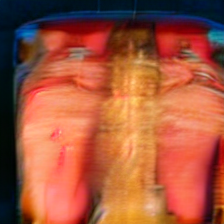

  0%|          | 0/50 [00:00<?, ?it/s]

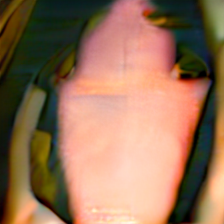

  0%|          | 0/50 [00:00<?, ?it/s]

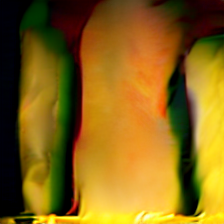

  0%|          | 0/50 [00:00<?, ?it/s]

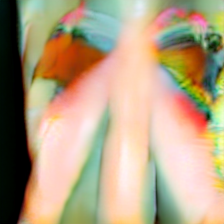

  0%|          | 0/50 [00:00<?, ?it/s]

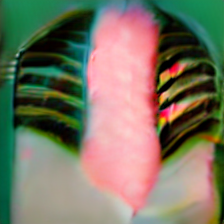

  0%|          | 0/50 [00:00<?, ?it/s]

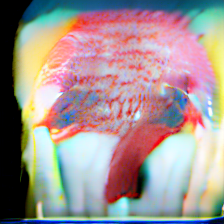

  0%|          | 0/50 [00:00<?, ?it/s]

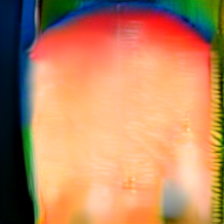

  0%|          | 0/50 [00:00<?, ?it/s]

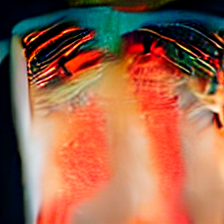

  0%|          | 0/50 [00:00<?, ?it/s]

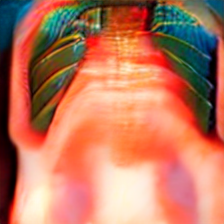

  0%|          | 0/50 [00:00<?, ?it/s]

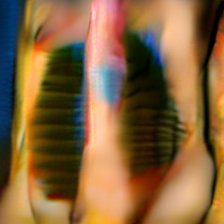

  0%|          | 0/50 [00:00<?, ?it/s]

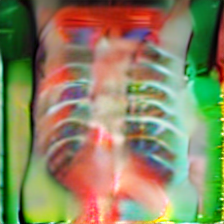

  0%|          | 0/50 [00:00<?, ?it/s]

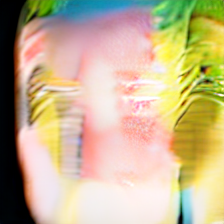

  0%|          | 0/50 [00:00<?, ?it/s]

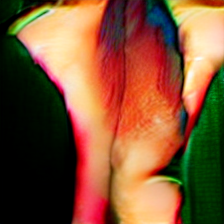

  0%|          | 0/50 [00:00<?, ?it/s]

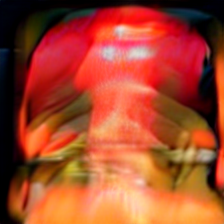

  0%|          | 0/50 [00:00<?, ?it/s]

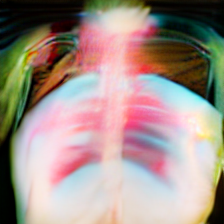

  0%|          | 0/50 [00:00<?, ?it/s]

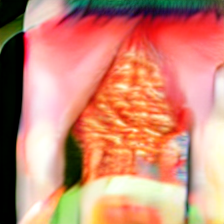

  0%|          | 0/50 [00:00<?, ?it/s]

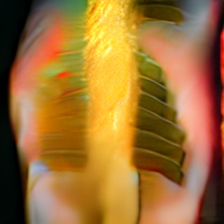

  0%|          | 0/50 [00:00<?, ?it/s]

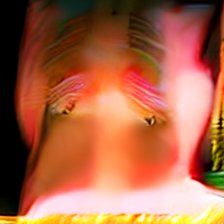

  0%|          | 0/50 [00:00<?, ?it/s]

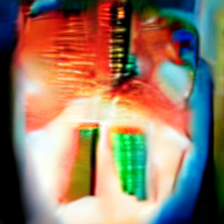

  0%|          | 0/50 [00:00<?, ?it/s]

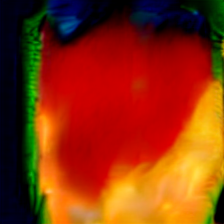

  0%|          | 0/50 [00:00<?, ?it/s]

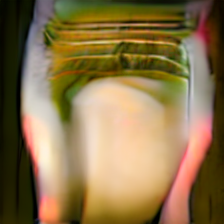

  0%|          | 0/50 [00:00<?, ?it/s]

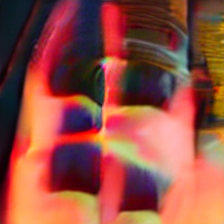

  0%|          | 0/50 [00:00<?, ?it/s]

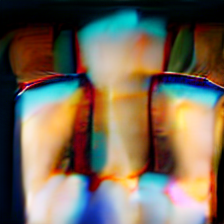

  0%|          | 0/50 [00:00<?, ?it/s]

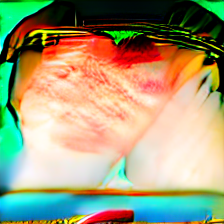

  0%|          | 0/50 [00:00<?, ?it/s]

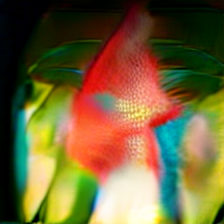

  0%|          | 0/50 [00:00<?, ?it/s]

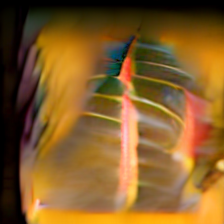

  0%|          | 0/50 [00:00<?, ?it/s]

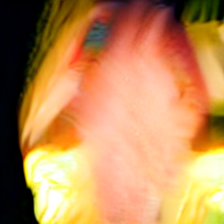

  0%|          | 0/50 [00:00<?, ?it/s]

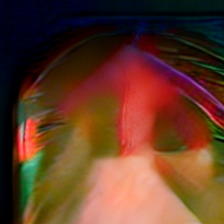

  0%|          | 0/50 [00:00<?, ?it/s]

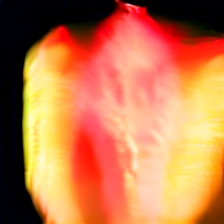

  0%|          | 0/50 [00:00<?, ?it/s]

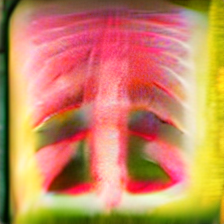

  0%|          | 0/50 [00:00<?, ?it/s]

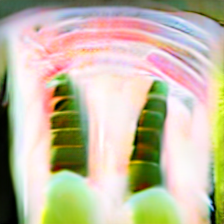

  0%|          | 0/50 [00:00<?, ?it/s]

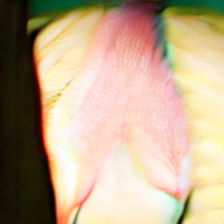

  0%|          | 0/50 [00:00<?, ?it/s]

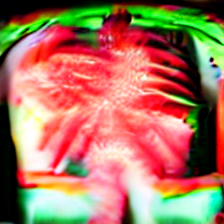

  0%|          | 0/50 [00:00<?, ?it/s]

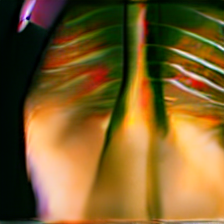

  0%|          | 0/50 [00:00<?, ?it/s]

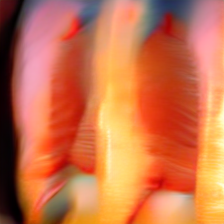

  0%|          | 0/50 [00:00<?, ?it/s]

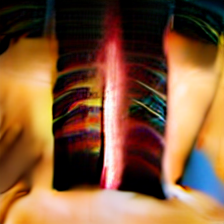

  0%|          | 0/50 [00:00<?, ?it/s]

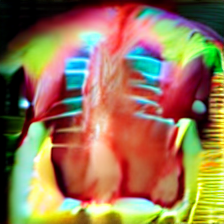

  0%|          | 0/50 [00:00<?, ?it/s]

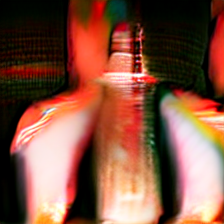

  0%|          | 0/50 [00:00<?, ?it/s]

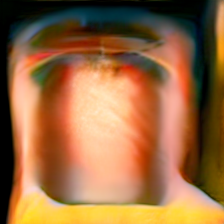

  0%|          | 0/50 [00:00<?, ?it/s]

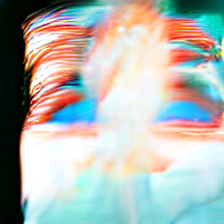

  0%|          | 0/50 [00:00<?, ?it/s]

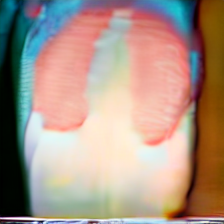

  0%|          | 0/50 [00:00<?, ?it/s]

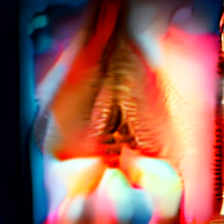

  0%|          | 0/50 [00:00<?, ?it/s]

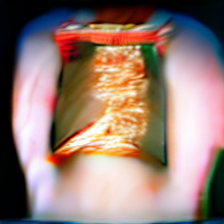

  0%|          | 0/50 [00:00<?, ?it/s]

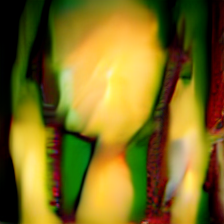

  0%|          | 0/50 [00:00<?, ?it/s]

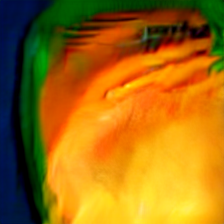

  0%|          | 0/50 [00:00<?, ?it/s]

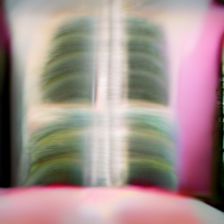

  0%|          | 0/50 [00:00<?, ?it/s]

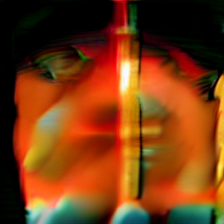

  0%|          | 0/50 [00:00<?, ?it/s]

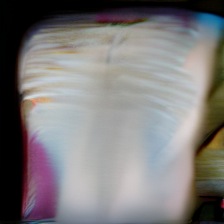

  0%|          | 0/50 [00:00<?, ?it/s]

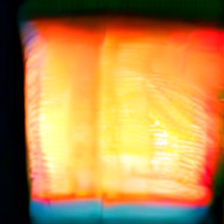

  0%|          | 0/50 [00:00<?, ?it/s]

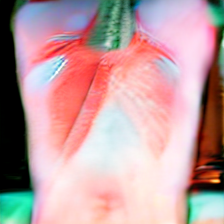

  0%|          | 0/50 [00:00<?, ?it/s]

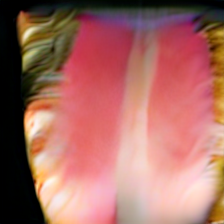

  0%|          | 0/50 [00:00<?, ?it/s]

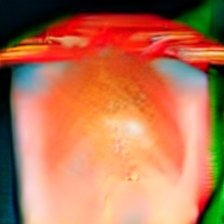

  0%|          | 0/50 [00:00<?, ?it/s]

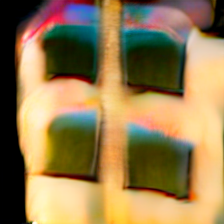

  0%|          | 0/50 [00:00<?, ?it/s]

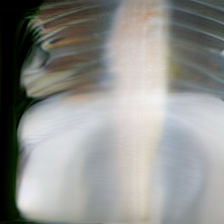

  0%|          | 0/50 [00:00<?, ?it/s]

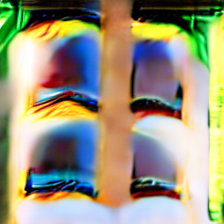

  0%|          | 0/50 [00:00<?, ?it/s]

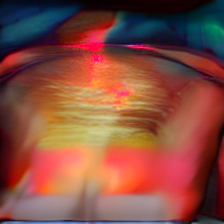

  0%|          | 0/50 [00:00<?, ?it/s]

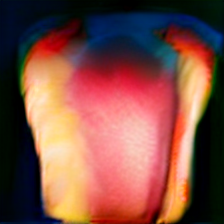

  0%|          | 0/50 [00:00<?, ?it/s]

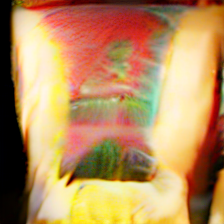

  0%|          | 0/50 [00:00<?, ?it/s]

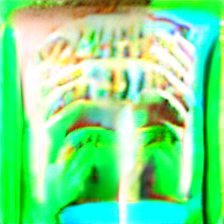

  0%|          | 0/50 [00:00<?, ?it/s]

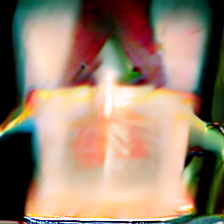

  0%|          | 0/50 [00:00<?, ?it/s]

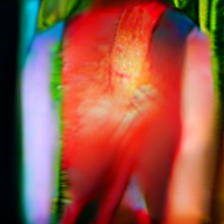

  0%|          | 0/50 [00:00<?, ?it/s]

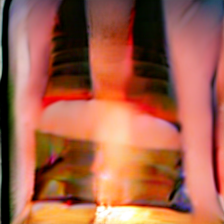

  0%|          | 0/50 [00:00<?, ?it/s]

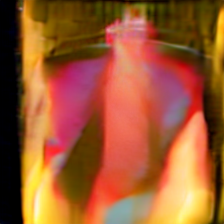

  0%|          | 0/50 [00:00<?, ?it/s]

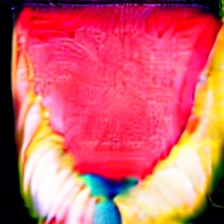

Image generation completed. Check the output directory for results.


In [16]:
from diffusers import StableDiffusionPipeline
from PIL import Image

# Ensure models are in evaluation mode and clear cache
unet_lora.eval()
text_encoder_lora.eval()
clear_cache()

"""
Assembles a customized Stable Diffusion pipeline for image generation
using the fine-tuned components (best_text_encoder, best_unet, etc.)
alongside old components (vae, noise scheduler, tokenizer, etc.)
"""
new_pipe = StableDiffusionPipeline(
    vae=vae,  # Pretrained VAE
    text_encoder=text_encoder_lora,  # Fine-tuned text encoder
    tokenizer=tokenizer,  # Pretrained tokenizer
    unet=unet_lora,  # Fine-tuned UNet
    scheduler=noise_scheduler,  # Pretrained noise scheduler
    safety_checker=None,  # Disable safety checker for simplicity
    feature_extractor=None,  # Not used in this fine-tuning task
)
# Move the pipeline to the appropriate device
new_pipe.to(device)

# Create necessary directories for saving images
check_and_make_folder(f'{save_result_path}/{folder_name}')
check_and_make_folder(f'{save_result_path}/{folder_name}/test_images')

# Generate images for the test dataset
for place in range(len(test_df)):
    temp_prompt = test_df.findings.iloc[place]  # Get the prompt text from the test dataset

    # Generate a new 224x224 image from the input prompt
    temp = new_pipe(temp_prompt, height=224, width=224).images[0]

    # Save the generated image
    temp.save(f'{save_result_path}/{folder_name}/test_images/{place}.png')

    # Optionally display the generated image in the notebook
    display(temp)

print("Image generation completed. Check the output directory for results.")
